In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch 
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [16]:
# Rutas de los archivos
train_files = glob('mnist/train/*/*.png')
valid_files = glob('mnist/valid/*/*.png')
test_files = glob('mnist/test/*/*.png')

print('Primer ruta es: ',train_files[0])

# Se vueleven aleatorios los archivos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

print('Las longitudes son: train {}, valid {}, test {}'.format(len(train_files), len(valid_files), len(test_files)))

# Se cargan las imagenes en las listas
# Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append(int(train_file.split('/')[2]))
    X_train.append(np.array(Image.open(train_file)))

# Datos de validación 
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append(int(valid_file.split('/')[2]))
    X_valid.append(np.array(Image.open(valid_file)))

# Datos de prueba
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append(int(test_file.split('/')[2]))
    X_test.append(np.array(Image.open(test_file)))

print('Verificamos las longitudes: Tr {}, V {}, Te {}'.format(len(X_train), len(X_valid), len(X_test)))


def tamanio (archivos,porcentaje):
    X = archivos[0][:int(len(archivos[0])*porcentaje)]
    Y = archivos[1][:int(len(archivos[1])*porcentaje)]
    # Se vuelven tensores
    X,Y=tensor(X,Y)
    print('Verificamos las longitudes: Antes {}, Despues {}'.format([len(archivos[0]),len(archivos[0][0])], X.data.size()))
    return X,Y

def tensor (X,Y):
    X = Variable(torch.from_numpy(np.array(X))).float()
    Y = Variable(torch.from_numpy(np.array(Y))).long()
    return X,Y


def red(X_train,Y_train,X_valid,Y_valid,X_test, Y_test):
    # Dimensiones de la red neuronal
    input_dim = 28*28
    out_dim = 10
    hidden = 50

    # Se hace el modelo con las dimensiones anteriores
    model = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),       
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),       
      torch.nn.Linear(hidden, out_dim)
    )

    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()


    # Numero de epocas
    n_epoch = 100

    # Listas de evaluacion del entrenamiento
    loss_train = []
    f1_train = []
    acc_train = []

    # Listas de evaluacion de la validacion
    loss_valid = []
    f1_valid = []
    acc_valid = []

    # Se entrena la red
    for epoch in range(n_epoch):
        model.train()

        Xtr = X_train.view(X_train.size(0), -1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train)
        loss_train.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_train.append( f1_score(Y_train,Y_pred, average='macro') )

        acc = sum(Y_train == Y_pred)/len(Y_pred)
        acc_train.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1)%25==0:
            print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

        model.eval()
        Xvl = X_valid.view(X_valid.size(0), -1)
        Y_pred = model(Xvl)  
        loss = criterion(Y_pred,Y_valid)
        loss_valid.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

        acc = sum(Y_valid == Y_pred)/len(Y_pred)
        acc_valid.append(acc)
        
    model.eval()

    Xts = X_test.view(X_test.size(0), -1)
    Y_pred = model(Xts)  
    loss = criterion(Y_pred,Y_test)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_test, Y_pred, average='macro')

    acc = sum(Y_test == Y_pred)/len(Y_pred)

    return n_epoch,loss_train,loss_valid,f1_train,f1_valid,acc_train,acc_valid,loss.item(), f1, acc

def grafica(n_epoch,loss_train,loss_valid,f1_train,f1_valid,acc_train,acc_valid,tipo,p):
    # Se evalua el desempeño de la red
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('{} al {}%'.format(tipo,int(p*100)))
    plt.subplot(1,3,1)
    plt.plot(range(n_epoch), loss_train, label='train')
    plt.plot(range(n_epoch), loss_valid, label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.subplot(1,3,2)
    plt.plot(range(n_epoch), f1_train, label='train')
    plt.plot(range(n_epoch), f1_valid, label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('f1_score')
    plt.legend()
    plt.grid()
    plt.subplot(1,3,3)
    plt.plot(range(n_epoch), acc_train, label='train')
    plt.plot(range(n_epoch), acc_valid, label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.savefig('./curves_ok_{}_{}.png'.format(tipo,int(p*100)), bbox_inches='tight')
    plt.show()


def metodo (tipo):
    perc = [0.1, 0.2, 0.5, 0.8, 1]
    for p in perc:
        print(' Se esta haciendo con el {}% de los datos de entrenamiento'.format(int(p*100)))
        X_train_p, Y_train_p = X_train, Y_train
        X_valid_p, Y_valid_p = X_valid, Y_valid
        X_test_p, Y_test_p = X_test, Y_test
        if tipo == 'Train':
            X_train_p, Y_train_p = tamanio([X_train_p,Y_train_p],p)
            X_valid_p, Y_valid_p = tensor(X_valid_p, Y_valid_p)
            X_test_p, Y_test_p = tensor(X_test_p, Y_test_p)
        elif tipo == 'Valid':
            X_train_p, Y_train_p = tensor(X_train_p,Y_train_p)
            X_valid_p, Y_valid_p = tamanio([X_valid_p, Y_valid_p],p)
            X_test_p, Y_test_p = tensor(X_test_p, Y_test_p)
        elif tipo == 'Test':
            X_train_p, Y_train_p = tensor(X_train_p,Y_train_p)
            X_valid_p, Y_valid_p = tensor(X_valid_p, Y_valid_p)
            X_test_p, Y_test_p = tamanio([X_test_p, Y_test_p],p)
        else: 
            raise Exception('No es un tipo valido')
            
        n_epoch,loss_train,loss_valid,f1_train,f1_valid,acc_train,acc_valid,loss,f1,acc=red(X_train_p,Y_train_p,X_valid_p,Y_valid_p,X_test_p,Y_test_p)
        print('')
        print('')
        print('Con {}% del conjunto {} se tiene: loss: {}, f1: {}, acc: {}'.format(int(p*100),tipo,loss, f1, acc))
        if tipo == 'Train' or tipo == 'Valid':
            grafica(n_epoch,loss_train,loss_valid,f1_train,f1_valid,acc_train,acc_valid,tipo,p)
        print('')
        print('')

Primer ruta es:  mnist/train/9/4968.png
Las longitudes son: train 6000, valid 2000, test 992
Verificamos las longitudes: Tr 6000, V 2000, Te 992


 Se esta haciendo con el 10% de los datos de entrenamiento
Verificamos las longitudes: Antes [6000, 28], Despues torch.Size([600, 28, 28])
Epoch [25/100], loss: 0.2905328869819641. f1:0.9088201208290142 acc: 0.9083333611488342 
Epoch [50/100], loss: 0.038830313831567764. f1:0.9964167831293815 acc: 0.996666669845581 
Epoch [75/100], loss: 0.012609580531716347. f1:1.0 acc: 1.0 
Epoch [100/100], loss: 0.006634830497205257. f1:1.0 acc: 1.0 


Con 10% del conjunto Train se tiene: loss: 0.8686851859092712, f1: 0.8056264816899452, acc: 0.8064516186714172


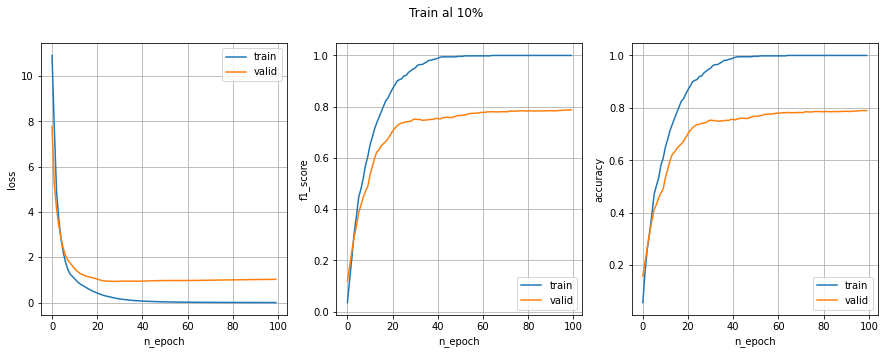



 Se esta haciendo con el 20% de los datos de entrenamiento
Verificamos las longitudes: Antes [6000, 28], Despues torch.Size([1200, 28, 28])
Epoch [25/100], loss: 0.4882546365261078. f1:0.8532628293301467 acc: 0.8516666889190674 
Epoch [50/100], loss: 0.12062329798936844. f1:0.9670835746037707 acc: 0.9666666388511658 
Epoch [75/100], loss: 0.043001770973205566. f1:0.993279622514639 acc: 0.9933333396911621 
Epoch [100/100], loss: 0.020397568121552467. f1:0.9991296285784564 acc: 0.9991666674613953 


Con 20% del conjunto Train se tiene: loss: 0.6788983345031738, f1: 0.8367167307531698, acc: 0.836693525314331


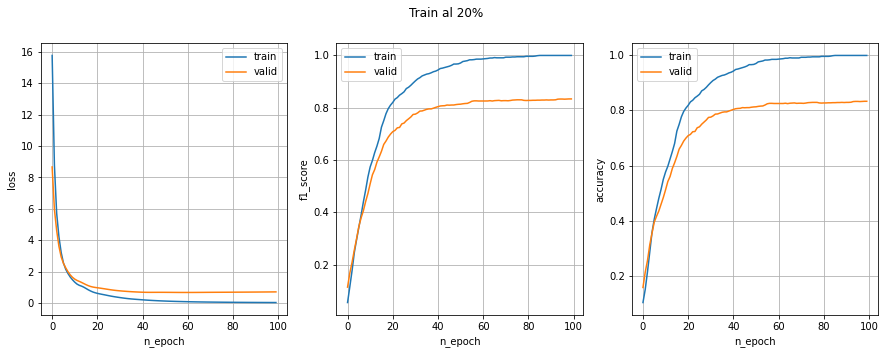



 Se esta haciendo con el 50% de los datos de entrenamiento
Verificamos las longitudes: Antes [6000, 28], Despues torch.Size([3000, 28, 28])
Epoch [25/100], loss: 0.33394548296928406. f1:0.9032792568671274 acc: 0.903333306312561 
Epoch [50/100], loss: 0.11159788817167282. f1:0.9709657473523174 acc: 0.9710000157356262 
Epoch [75/100], loss: 0.04835323616862297. f1:0.9913541674887625 acc: 0.9913333058357239 
Epoch [100/100], loss: 0.02615431137382984. f1:0.9967229883779185 acc: 0.996666669845581 


Con 50% del conjunto Train se tiene: loss: 0.37521663308143616, f1: 0.899618252443584, acc: 0.9002016186714172


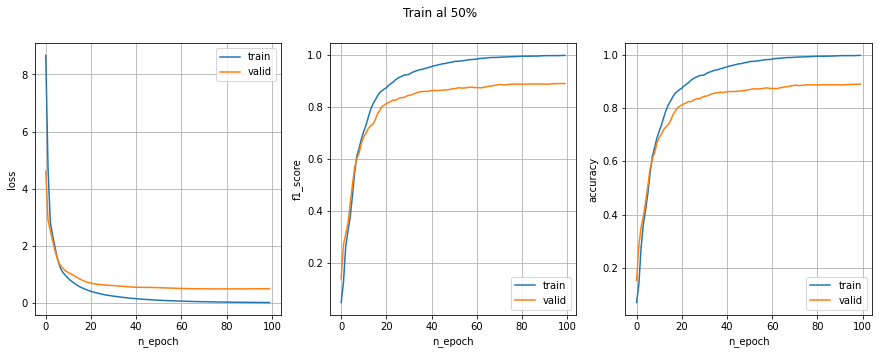



 Se esta haciendo con el 80% de los datos de entrenamiento
Verificamos las longitudes: Antes [6000, 28], Despues torch.Size([4800, 28, 28])
Epoch [25/100], loss: 0.6663793325424194. f1:0.8098758062003688 acc: 0.8102083206176758 
Epoch [50/100], loss: 0.3138563632965088. f1:0.9048420773820907 acc: 0.9045833349227905 
Epoch [75/100], loss: 0.18750354647636414. f1:0.9443518592727186 acc: 0.9441666603088379 
Epoch [100/100], loss: 0.12213634699583054. f1:0.9671533860131509 acc: 0.9670833349227905 


Con 80% del conjunto Train se tiene: loss: 0.4299093186855316, f1: 0.8815923654508492, acc: 0.882056474685669


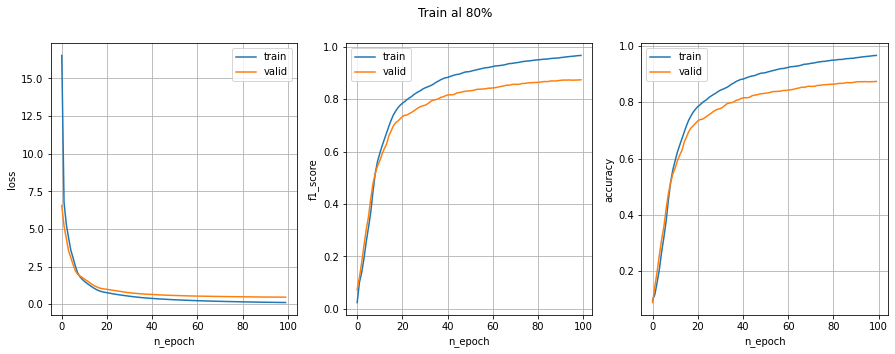



 Se esta haciendo con el 100% de los datos de entrenamiento
Verificamos las longitudes: Antes [6000, 28], Despues torch.Size([6000, 28, 28])
Epoch [25/100], loss: 0.6429317593574524. f1:0.8013276600430531 acc: 0.8028333187103271 
Epoch [50/100], loss: 0.3225485682487488. f1:0.9052455638281005 acc: 0.9053333401679993 
Epoch [75/100], loss: 0.21419036388397217. f1:0.9359878198379888 acc: 0.9359999895095825 
Epoch [100/100], loss: 0.15706336498260498. f1:0.9580042980058462 acc: 0.9580000042915344 


Con 100% del conjunto Train se tiene: loss: 0.36001724004745483, f1: 0.8920309358482692, acc: 0.8921371102333069


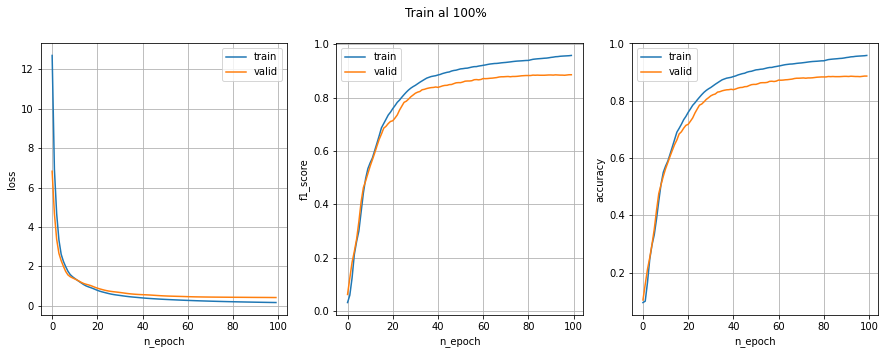

In [17]:
metodo('Train')

En este primer caso se tomaron diferente porcentajes del conjunto de entrenamiento. En primera instancia solo comparando los valores de perdida, del f1 y de la accuracy del 10% y del 100% podemos ver un gran cambio. En el del 10% hay una perdida del 0.9 que es bastante grande y nos está diciendo que nuestro modelo no es para nada bueno. Luego, a medida que el porcentaje de datos aumenta vemos que la perdida disminuye. En el caso del f1 y de la accuracy, como se esperaba, aumenta a medida que el tamaño del conjunto de datos aumenta. Esto además también se ve reflejado en las gráficas ya que a medida que aumenta el tamaño del conjunto de entrnamiento podemos ver que los valores de perdida, f1 y accuracy del modelo con el grupo de entrenamiento y de validación se acercan cada vez más. Es por esto que para poder entrenar un modelo al que se le pueda tener confianza de para predicciones futuras, se necesita un conjunto de entrenamiento grande, mientras más grande, mejor.

In [18]:
metodo('Test')

 Se esta haciendo con el 10% de los datos de entrenamiento
Verificamos las longitudes: Antes [992, 28], Despues torch.Size([99, 28, 28])
Epoch [25/100], loss: 0.6265701651573181. f1:0.8107524717040622 acc: 0.8109999895095825 
Epoch [50/100], loss: 0.3150555491447449. f1:0.9043712003477049 acc: 0.9045000076293945 
Epoch [75/100], loss: 0.19554270803928375. f1:0.942800709216244 acc: 0.9428333044052124 
Epoch [100/100], loss: 0.13179592788219452. f1:0.964997336446617 acc: 0.9649999737739563 


Con 10% del conjunto Test se tiene: loss: 0.6215693354606628, f1: 0.809650638032991, acc: 0.8383838534355164


 Se esta haciendo con el 20% de los datos de entrenamiento
Verificamos las longitudes: Antes [992, 28], Despues torch.Size([198, 28, 28])
Epoch [25/100], loss: 0.6119992733001709. f1:0.8243662391907861 acc: 0.8258333206176758 
Epoch [50/100], loss: 0.31321635842323303. f1:0.9028875426824363 acc: 0.902999997138977 
Epoch [75/100], loss: 0.1995019167661667. f1:0.941608784587013 acc: 0.9416666

En este caso nos podemos dar cuenta que no solo es necesario un conjunto de datos de entrenamiento grande, sino además uno para probar el modelo. En este caso, el valor de perdida aumenta a medida de que el porcentaje de datos de prueba aumenta. Esto se debe a que más datos son evaluados y se puede tener mayor certeza del porcentaje de perdida que se tiene y no solo porque justo esos datos concuerden. Algo similar pasa con los valores f1 y de accuracy, ya que a medida que el porcentaje de los datos de testeo aumenta, el valos de f1 y acc disminuye; esto se debe a que más datos muestran qué tanto se está o no equivocando el modelo. Es por esto que se debe buscar maximizar la cantidad de datos de los tres tipos, para poder confiar en el aprendizaje de la ANN.